In [15]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import geopandas
from openai import OpenAI
from sklearn.preprocessing import MinMaxScaler

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

# import openAI to query chatGPT within notebook
with open('/content/drive/MyDrive/apikey.txt', 'r') as f:
    openai_api_key = f.read().strip()

client = OpenAI(
    api_key=openai_api_key
)

# enable text wrapping in output cells
from IPython.display import HTML, display

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)

In [4]:
file_path = '/content/drive/MyDrive/senator_twitter_May-Oct.csv'
senator_df = pd.read_csv(file_path)

senator_df.head(5)

,Unnamed: 0.1,Unnamed: 0,tweet_id,time,text,replies,retweets,likes,from_user,from_content,twitter_id,name,state,party,gender,birth,age
0,4014,37,1322145371108331520,2020-10-30 11:56:35,More jobs. More investment. More economic oppo...,40,24,143,NaN,NaN,BrianKempGA,Brian Kemp,GA,Republican,Male,NaN,57
1,4015,38,1321926867696390144,2020-10-29 21:28:20,Marty and I are excited to be back on the camp...,46,26,107,NaN,NaN,BrianKempGA,Brian Kemp,GA,Republican,Male,NaN,57
2,4016,39,1321906471244845061,2020-10-29 20:07:17,ICYMI: Gov. Kemp announces 46 people snared in...,24,30,174,NaN,NaN,BrianKempGA,Brian Kemp,GA,Republican,Male,NaN,57
3,4017,40,1321517100398268416,2020-10-28 18:20:03,I promised that Georgia would stop and dismant...,29,37,173,NaN,NaN,BrianKempGA,Brian Kemp,GA,Republican,Male,NaN,57
4,4018,41,1321478513988423680,2020-10-28 15:46:44,"Now or on November 3rd, vote for the political...",88,35,159,Kelly Loeffler,We are now less than a week away from the most...,BrianKempGA,Brian Kemp,GA,Republican,Male,NaN,57


In [72]:
# get 1 row per state + senator and their corresponding party
grouped = senator_df.groupby(['state','name'])
result = grouped.first().reset_index()
final_df = result[['state', 'name', 'party']]

# get count of tweets per state/senator
tweet_counts = grouped.size()
tweet_counts = tweet_counts.reset_index(name='tweet_count')

# merge senator info + tweet counts into one df
merged_df = pd.merge(final_df, tweet_counts, on=['state', 'name'], how='left')
merged_df.head(5)

,state,name,party,tweet_count
0,AK,Mike Dunleavy,Republican,219
1,AL,Kay Ivey,Republican,524
2,AZ,Doug Ducey,Republican,1323
3,CA,Gavin Newsom,Democratic,512
4,CO,Jared Polis,Democratic,122


Scatterplot of tweet count

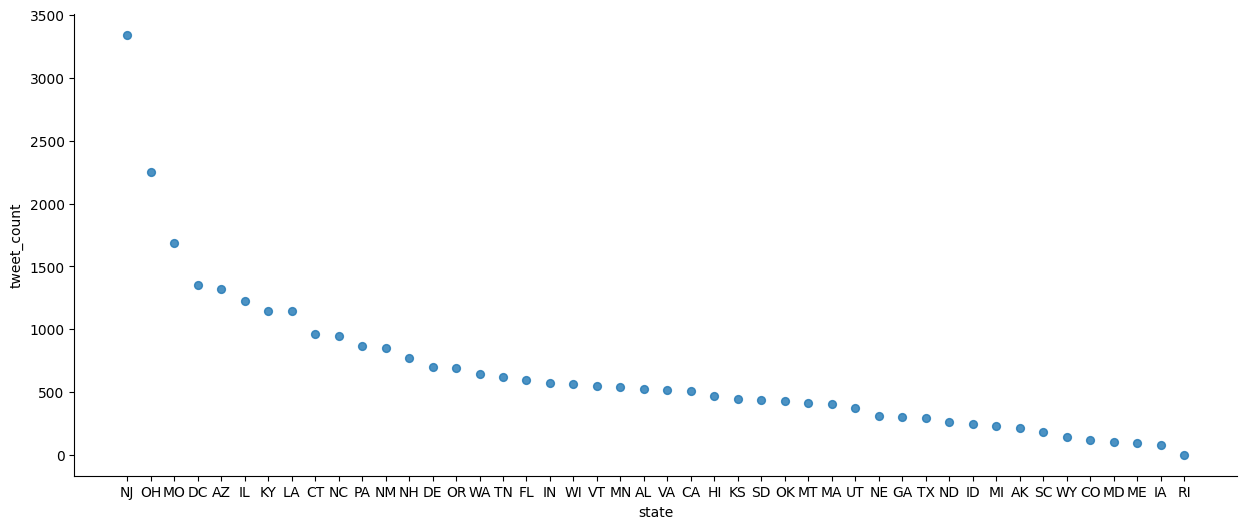

In [78]:
merged_df_sorted = merged_df.sort_values(by='tweet_count', ascending=False)
merged_df_sorted = merged_df_sorted.reset_index(drop=True) # reset index and drop old index
merged_df_sorted.reset_index().plot(kind='scatter', x='state', y='tweet_count', s=32, alpha=.8, figsize=(15, 6))

plt.gca().spines[['top', 'right',]].set_visible(False)

In [79]:
merged_df_sorted.head(5)

,state,name,party,tweet_count
0,NJ,Phil Murphy,Democratic,3342
1,OH,Mike DeWine,Republican,2252
2,MO,Mike Parson,Republican,1685
3,DC,Muriel Bowser,Democratic,1351
4,AZ,Doug Ducey,Republican,1323


In [5]:
states = [
    "AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DE", "FL", "GA",
    "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD",
    "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ",
    "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC",
    "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"
]

df_states = senator_df['state'].unique()

# get list of which states are not included
missing_states = [state for state in states if state not in df_states]
extra_states = [state for state in df_states if state not in states]
print(missing_states) # expecting 4 but got 5...
print(extra_states) # the extra state in our dataset

['AR', 'MS', 'NV', 'NY', 'WV']
['DC']


In [6]:
states = geopandas.read_file('/content/drive/MyDrive/us-state-boundaries/us-state-boundaries.shp')
states = states.to_crs(epsg=3395)

# drop non-contiguous states and plot with random color (for now)
contig_48 = states.drop([0,5,21,29,30,31,38,53])

# define party colors
party_colors = {'Democratic': 'lightblue',  'Republican': 'red'}

# merge geodata & senator tweet data into single dataframe
merged_states = contig_48.merge(merged_df, left_on='stusab', right_on='state', how='left')
merged_states['color'] = merged_states['party'].map(party_colors)

# create custom color map based on party affiliation
cmap = ListedColormap(list(party_colors.values()))

-8310480.408384257 4855727.497630035


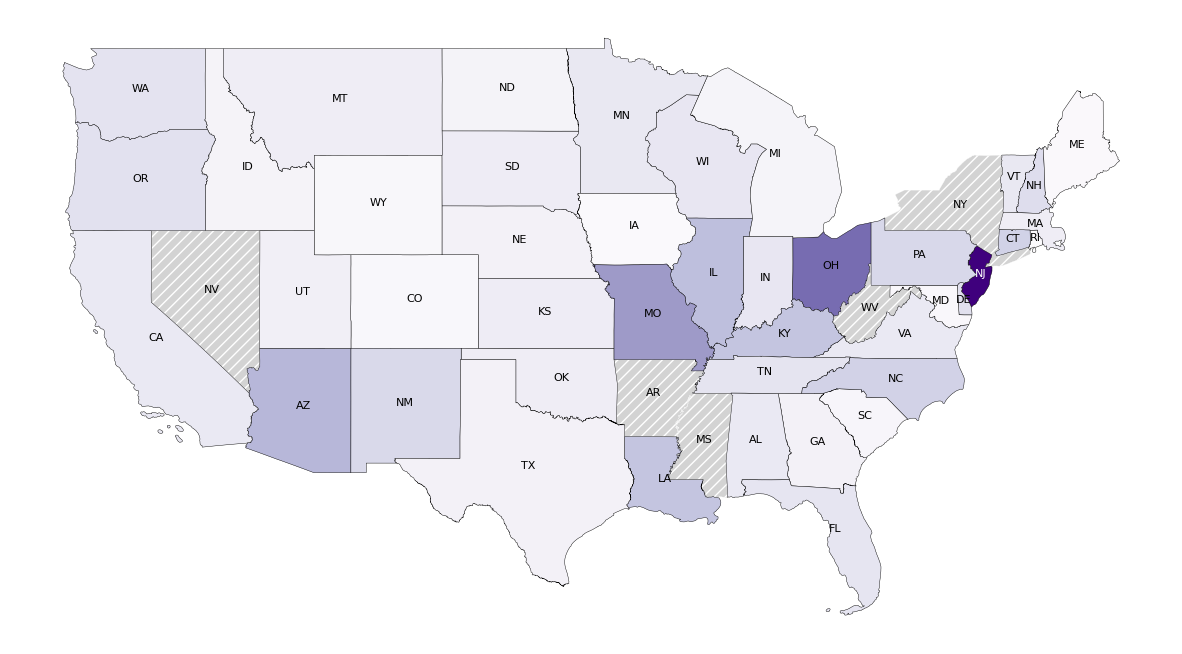

In [38]:
# normalize tweet counts across all senators
scaler = MinMaxScaler()
merged_states['normalized_tweets'] = scaler.fit_transform(merged_states[['tweet_count']])

# plot political party with separate colormaps
fig, ax = plt.subplots(figsize=(15, 10))

# Base layer: all 50 states
contig_48.plot(
    ax=ax,
    color= "lightgrey",
    edgecolor= "white",
    hatch= "///",
    linewidth=0.2
)

# overlay all states with color intensity normalized by tweet count
merged_states.plot(
    ax=ax,
    column='normalized_tweets',
    cmap='Purples',
    edgecolor='black',
    linewidth=0.3
)

# include state labels
for idx, row in merged_states.iterrows():
    # Get centroid coordinates
    centroid = row['geometry'].centroid

    # handle case where centroid is point
    if centroid.geom_type == 'Point':
        x, y = centroid.coords[0]
    # handle other geometry types
    else:
        x, y = centroid.x, centroid.y

    if row['stusab'] == 'NJ':
      ax.text(x+15000, y, row['stusab'], fontsize=8, ha='center', color='white')
    else:
      ax.text(x, y, row['stusab'], fontsize=8, ha='center', color='black')


ax.set_axis_off()
plt.show()

Plot frequency of tweets normalized within each political party

-8310480.408384257 4855727.497630035


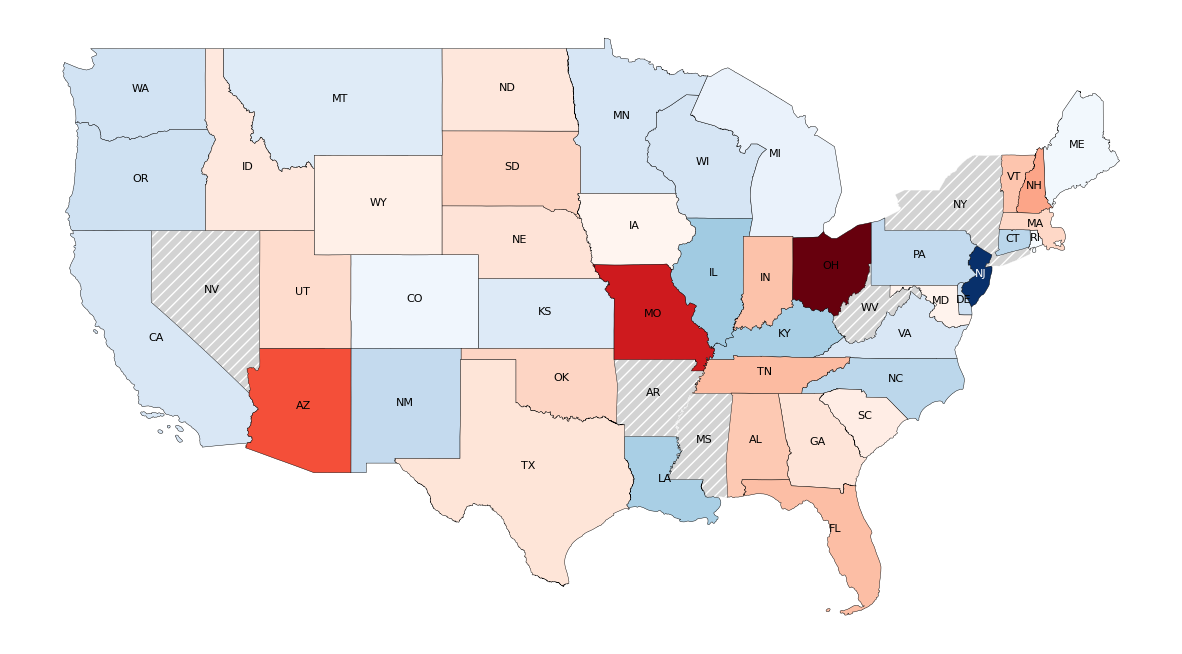

In [40]:
# create separate normalized tweet columns for Democrats and Republicans
democrat_states = merged_states[merged_states['party'] == 'Democratic']
democrat_states['normalized_tweets'] = scaler.fit_transform(democrat_states[['tweet_count']])

republican_states = merged_states[merged_states['party'] == 'Republican']
republican_states['normalized_tweets'] = scaler.fit_transform(republican_states[['tweet_count']])

# plot political party with separate colormaps
fig, ax = plt.subplots(figsize=(15, 10))

# base layer: all 50 states
contig_48.plot(
    ax=ax,
    color= "lightgrey",
    edgecolor= "white",
    hatch= "///",
    linewidth=0.2
)

# overlay democrat & republican states
democrat_states.plot(
    ax=ax,
    column='normalized_tweets',
    cmap='Blues',
    edgecolor='black',
    linewidth=0.3
)

republican_states.plot(
    ax=ax,
    column='normalized_tweets',
    cmap='Reds',
    edgecolor='black',
    linewidth=0.3
)

# include state labels
for idx, row in merged_states.iterrows():
    # Get centroid coordinates
    centroid = row['geometry'].centroid

    # handle case where centroid is point
    if centroid.geom_type == 'Point':
        x, y = centroid.coords[0]
    # handle other geometry types
    else:
        x, y = centroid.x, centroid.y

    if row['stusab'] == 'NJ':
      ax.text(x+15000, y, row['stusab'], fontsize=8, ha='center', color='white')
    else:
      ax.text(x, y, row['stusab'], fontsize=8, ha='center', color='black')

ax.set_axis_off()
plt.show()

Things of note
*   Missing states: 'AR', 'MS', 'NV', 'NY', 'WV'
*   Extra states: 'DC'
* Democratic senator with the most tweets: Phil Murphy (NJ)
* Republican senator with the most tweets: Mike DeWine (OH)



Who is the mystery person from DC who snuck into our dataset?

In [ ]:
response = client.chat.completions.create(
    model="gpt-4o-mini",
    messages=[{
      "role": "user",
      "content": f"Who is {unique_values['DC']}? Was he/she ever a senator of the United States?"}
])

['Muriel Bowser']


In [ ]:
print(response.choices[0].message.content)

Muriel Bowser is an American politician who has served as the Mayor of Washington, D.C., since January 2015. She is a member of the Democratic Party and was previously a member of the D.C. Council representing Ward 4. Muriel Bowser has never been a senator of the United States. Instead, she is known for her leadership in local government and her focus on issues such as affordable housing, education, and public safety in the District of Columbia.


Drop all tweets by Muriel Bowser (maybe)